# MODIS-WRF LST-TSK alignment validation testing

Validating the transformed MODIS and WRF data each step of the way.

Test locations:  
  * 64.8N, 147.7W - MODIS tile h11v02 (**L1**)
  * 65.5N, 143.8W - MODIS tile h12v02 (**L2**)
  
Test time periods:
  * 2008-01-01 to 2008-04-01 (**P1**)
  * 2018-07-01 to 2018-10-01 (**P2**)

## 1. MODIS LST

Goal: verify that the downloaded/converted MODIS matches the prepped MODIS.

Test: check for similarity of values (should not be the same because of resampling to the WRF grid) between preppd MODIS and manually queried data matching test locations/time periods. 

In [1]:
# setup
import os, glob, math, itertools, time
import xarray as xr
import pandas as pd
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from pyproj import Transformer
from datetime import datetime
from rasterio.windows import Window
from rasterio.plot import show
%matplotlib inline

test_coords = np.array([[-147.7, 64.8], [-143.8, 65.5]])
test_dates = np.array(
    [["2008-04-04", "2008-07-04"], ["2018-07-01", "2018-10-01"]], dtype="datetime64"
)

scratch_dir = os.getenv("SCRATCH_DIR")
mod_conv_dir = os.path.join(scratch_dir, "MODIS", "converted")

mod11_fps = sorted(glob.glob(os.path.join(mod_conv_dir, "*MOD11A2*h11*01.tif")))
myd11_fps = sorted(glob.glob(os.path.join(mod_conv_dir, "*MYD11A2*h11*01.tif")))
mod12_fps = sorted(glob.glob(os.path.join(mod_conv_dir, "*MOD11A2*h12*01.tif")))
myd12_fps = sorted(glob.glob(os.path.join(mod_conv_dir, "*MYD11A2*h12*01.tif")))

### Read converted MODIS data

In [2]:
# raw converted MODIS data filepaths to check against
mod_fp_dates = pd.to_datetime(
    [
        datetime.strptime(os.path.basename(fp).split("_")[1][1:], "%Y%j")
        for fp in mod11_fps
    ]
)

myd_fp_dates = pd.to_datetime(
    [
        datetime.strptime(os.path.basename(fp).split("_")[1][1:], "%Y%j")
        for fp in myd11_fps
    ]
)

mod_slices = [mod_fp_dates.slice_indexer(*daterange) for daterange in test_dates]
myd_slices = [myd_fp_dates.slice_indexer(*daterange) for daterange in test_dates]

In [3]:
# get indices for test locations
# tile h11v02
with rio.open(mod11_fps[mod_slices[0]][0]) as src:
    transformer = Transformer.from_crs(4326, src.meta["crs"], always_xy=True)
    mod_conv_coords = [pt for pt in transformer.itransform(test_coords)]
    mod11_id = src.index(*mod_conv_coords[0])
# tile h12v02
with rio.open(mod12_fps[mod_slices[0]][0]) as src:
    mod12_id = src.index(*mod_conv_coords[1])

In [4]:
# function to extract and rescale data from converted/warped tifs
def extr_arrs(fps, slices, idy, idx):
    arr = []
    for sl in slices:
        vals = []
        for fp in fps[sl]:
            src = rio.open(fp)
            vals.append(src.read(1)[idy,idx])
        arr.append(np.array(vals))
    out_arr = np.array(arr) * 0.02
    out_arr[out_arr == 0] = np.nan
    return out_arr

In [5]:
# extract data
mod11_arrs = extr_arrs(mod11_fps, mod_slices, *mod11_id)
mod12_arrs = extr_arrs(mod12_fps, mod_slices, *mod12_id)
myd11_arrs = extr_arrs(myd11_fps, myd_slices, *mod11_id)
myd12_arrs = extr_arrs(myd12_fps, myd_slices, *mod12_id)

### Read mosaicked MODIS data

In [6]:
# mosaicked MODIS files
mod_mos_dir = os.path.join(scratch_dir, "MODIS", "mosaicked")

mod_mos_fps = sorted(glob.glob(os.path.join(mod_mos_dir, "*MOD11A2*01.tif")))
myd_mos_fps = sorted(glob.glob(os.path.join(mod_mos_dir, "*MYD11A2*01.tif")))

In [7]:
with rio.open(mod_mos_fps[mod_slices[0]][0]) as src:
    transformer = Transformer.from_crs(4326, src.meta["crs"], always_xy=True)
    mod_mos_coords = [pt for pt in transformer.itransform(test_coords)]
    mod11_mos_id = src.index(*mod_mos_coords[0])
    mod12_mos_id = src.index(*mod_mos_coords[1])
    # read slice for image comparison
    mod_mos_sl = src.read(1) * 0.02

In [8]:
# extract data
mod11_mos_arrs = extr_arrs(mod_mos_fps, mod_slices, *mod11_mos_id)
mod12_mos_arrs = extr_arrs(mod_mos_fps, mod_slices, *mod12_mos_id)
myd11_mos_arrs = extr_arrs(myd_mos_fps, myd_slices, *mod11_mos_id)
myd12_mos_arrs = extr_arrs(myd_mos_fps, myd_slices, *mod12_mos_id)

### Compare mosaicked data with converted

Should see exact matches.

#### Delta histograms, `mosaicked - converted`

##### MOD11A2

In [9]:
def plot_delta_histograms(t_arrs1, t_arrs2, b_arrs1, b_arrs2):
    plot_arrs = []
    t_arrs = [t_arrs1, t_arrs2]
    b_arrs = [b_arrs1, b_arrs2]
    for t_arr, b_arr in zip(t_arrs, b_arrs):
        arr = t_arr - b_arr
        plot_arrs.append([sub_arr[~np.isnan(sub_arr)] for sub_arr in arr])
    fig, ax = plt.subplots(1,4, figsize=(15, 3))
    ax[0].hist(plot_arrs[0][0])
    ax[1].hist(plot_arrs[0][1])
    ax[2].hist(plot_arrs[1][0])
    ax[3].hist(plot_arrs[1][1])
    ax[0].title.set_text("L1, P1")
    ax[1].title.set_text("L1, P2")
    ax[2].title.set_text("L2, P1")
    ax[3].title.set_text("L2, P2")
    plt.show()

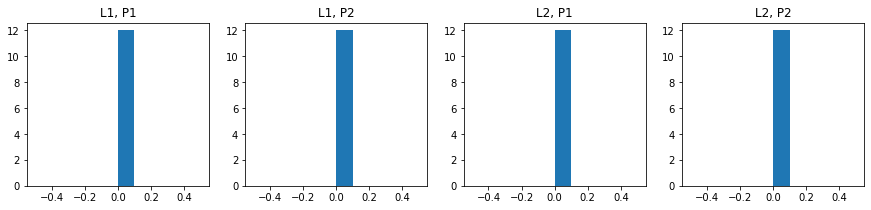

In [10]:
plot_delta_histograms(mod11_mos_arrs, mod12_mos_arrs, mod11_arrs, mod12_arrs)

##### MYD11A2

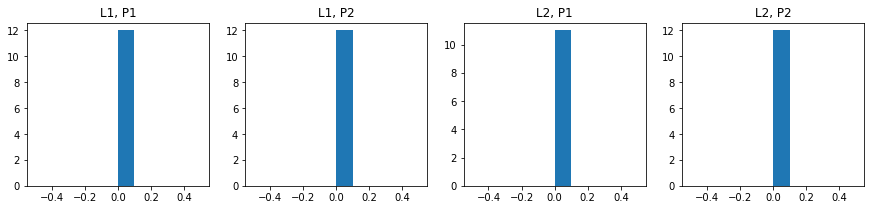

In [11]:
plot_delta_histograms(myd11_mos_arrs, myd12_mos_arrs, myd11_arrs, myd12_arrs)

Mosaicking is valid.

### Read warped MODIS data

In [12]:
# warped MODIS files
mod_warp_dir = os.path.join(scratch_dir, "MODIS", "warped")

mod_warp_fps = sorted(glob.glob(os.path.join(mod_warp_dir, "*MOD11A2*01.tif")))
myd_warp_fps = sorted(glob.glob(os.path.join(mod_warp_dir, "*MYD11A2*01.tif")))

In [13]:
with rio.open(mod_warp_fps[mod_slices[0]][0]) as src:
    tmp_meta = src.meta
    transformer = Transformer.from_crs(4326, src.meta["crs"], always_xy=True)
    mod_warp_coords = [pt for pt in transformer.itransform(test_coords)]
    mod11_warp_id = src.index(*mod_warp_coords[0])
    mod12_warp_id = src.index(*mod_warp_coords[1])
    # read slice
    mod_warp_sl = src.read(1) * 0.02

In [14]:
# extract data
mod11_warp_arrs = extr_arrs(mod_warp_fps, mod_slices, *mod11_warp_id)
mod12_warp_arrs = extr_arrs(mod_warp_fps, mod_slices, *mod12_warp_id)
myd11_warp_arrs = extr_arrs(myd_warp_fps, myd_slices, *mod11_warp_id)
myd12_warp_arrs = extr_arrs(myd_warp_fps, myd_slices, *mod12_warp_id)

### Compare warped data with mosaicked

#### Delta histograms, `warped - mosaicked`

##### MOD11A2

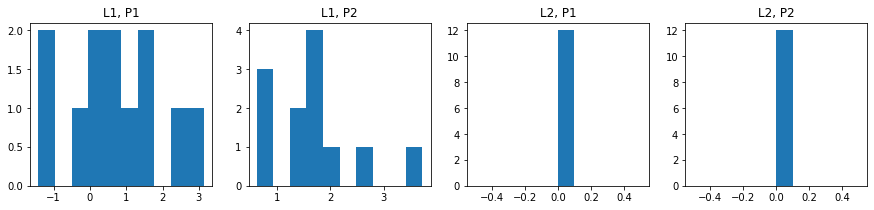

In [15]:
plot_delta_histograms(mod11_warp_arrs, mod12_warp_arrs, mod11_mos_arrs, mod12_mos_arrs)

##### MYD11A2

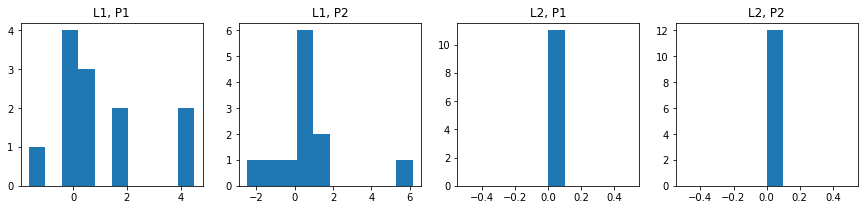

In [16]:
plot_delta_histograms(myd11_warp_arrs, myd12_warp_arrs, myd11_mos_arrs, myd12_mos_arrs)

Slight differences in values from re-projecting is expected. Check for equality at **L2**:

In [17]:
print("L2, P1 elementwise equal:", mod12_warp_arrs[0] == mod12_mos_arrs[0])
print("L2, P2 elementwise equal:", mod12_warp_arrs[1] == mod12_mos_arrs[1])

L2, P1 elementwise equal: [ True  True  True  True  True  True  True  True  True  True  True  True]
L2, P2 elementwise equal: [ True  True  True  True  True  True  True  True  True  True  True  True]


In [18]:
print("", mod11_warp_arrs[0] - mod11_mos_arrs[0])

 [ 0.14  3.14 -0.42  0.56  0.3  -1.24  1.32  0.48  2.68 -1.42  1.72  1.14]


Equal values between warp and mosaic for **L2**. Likely just an artifact of increased interpolation from warping at **L1**. Plot first time slice of **P1** for each type to assess warping:

#### Single time slice, 2008-01-01, `mosaicked`, `warped`

##### MOD11A2

In [19]:
mod_mos_sl[mod_mos_sl == 0] = np.nan
mod_warp_sl[mod_warp_sl == 0] = np.nan

In [20]:
# plot both projections with both locations showing
def plot_img_arrs(arr1, arr2, idx1, idx2, arr1_title, arr2_title, adj1=25, adj2=25):
    def set_red(arr, idx, adj):
        for rc in idx:
            arr[rc[0]:rc[0] + adj, rc[1]:rc[1] + adj,:3] = 0.99,0.05,0.75
        return arr

    arrs = [arr1, arr2]
    cmap = plt.cm.viridis
    norms = [plt.Normalize(np.nanmin(arr), np.nanmax(arr)) for arr in arrs]
    rgba = [cmap(norm(arr)) for norm, arr in zip(norms, arrs)]
    rgba[0] = set_red(rgba[0], idx1, adj1)
    rgba[1] = set_red(rgba[1], idx2, adj2)
    fig, ax = plt.subplots(1,2, figsize=(15,20))
    ax[0].imshow(rgba[0], interpolation="none", vmin=220, vmax=295)
    ax[1].imshow(rgba[1], interpolation="none", vmin=220, vmax=295)
    ax[0].title.set_text(arr1_title)
    ax[1].title.set_text(arr2_title)
    plt.show()

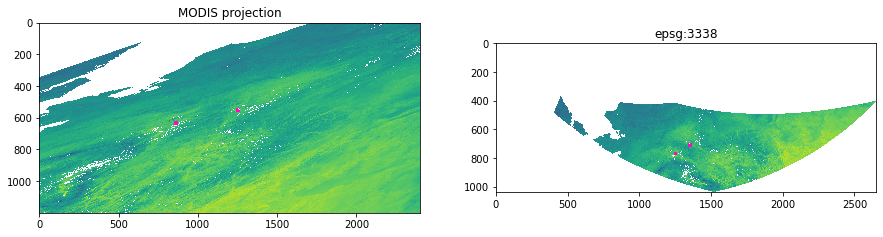

In [21]:
idx1 = [mod11_mos_id, mod12_mos_id]
idx2 = [mod11_warp_id, mod12_warp_id]
plot_img_arrs(mod_mos_sl, mod_warp_sl, idx1, idx2, "MODIS projection", "epsg:3338")

Warping is very evident, believe this to be sufficient validation for warped MODIS.

### Read output MODIS data

In [22]:
# prepped MODIS files
out_dir = os.getenv("OUTPUT_DIR")
mod_out_dir = os.path.join(out_dir, "aligned-WRF-MODIS", "MODIS")
mod_out_fp = sorted(glob.glob(os.path.join(mod_out_dir, "*.nc")))[0]
myd_out_fp = sorted(glob.glob(os.path.join(mod_out_dir, "*.nc")))[1]

In [23]:
# read and extract final prepped MODIS
def extr_out_arrs(fp, dates_list, coords):
    ds = xr.open_dataset(fp)
    loc_ds = ds.sel(xc=coords[0], yc=coords[1], method="nearest")
    return np.array([
        loc_ds.sel(date=dates).lst.values 
        for dates in dates_list
    ])

In [24]:
transformer = Transformer.from_crs(4326, 3338, always_xy=True)
test_coords_3338 = [pt for pt in transformer.itransform(test_coords)]

In [25]:
dates_list = [mod_fp_dates[sl].values for sl in mod_slices]
mod11_out_arrs = extr_out_arrs(mod_out_fp, dates_list, test_coords_3338[0])
mod12_out_arrs = extr_out_arrs(mod_out_fp, dates_list, test_coords_3338[1])
myd11_out_arrs = extr_out_arrs(myd_out_fp, dates_list, test_coords_3338[0])
myd12_out_arrs = extr_out_arrs(myd_out_fp, dates_list, test_coords_3338[1])

### Compare clipped (final) data with warped/rescaled

#### Delta histograms, `clipped - warped`

##### MOD11A2

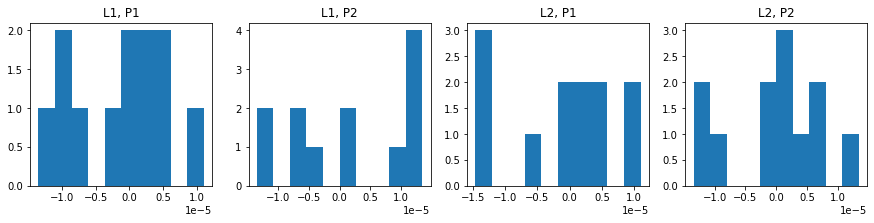

In [26]:
plot_delta_histograms(mod11_out_arrs, mod12_out_arrs, mod11_warp_arrs, mod12_warp_arrs)

##### MYD11A2

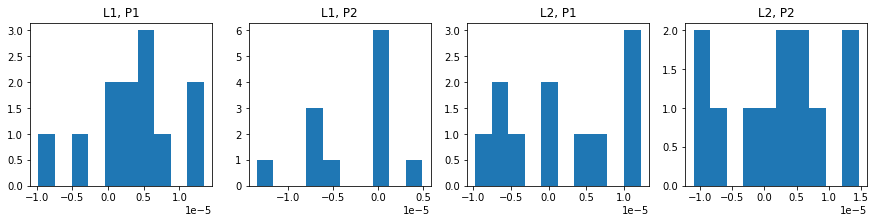

In [27]:
plot_delta_histograms(myd11_out_arrs, myd12_out_arrs, myd11_warp_arrs, myd12_warp_arrs)

Differences are miniscule, as are expected from clipping to the WRF extent. 

#### Single time slice, 2008-01-01, `warped`, `clipped`

##### MOD11A2

Compare a whole slice of time from warped and clipped. There are two sources of clipped, the inidividual GeoTIFFs and the NetCDFs.

In [28]:
# extract slice from the multiband NetCDF
def extr_slice(fp, date):
    ds = xr.open_dataset(fp)
    return ds.lst.sel(date=date).values

In [29]:
# first time slice for P1
mod_out_mb_sl = extr_slice(mod_out_fp, dates_list[0][0])

In [30]:
# read a tif for clipping index
mod_warp_fp = mod_warp_fps[mod_slices[0]][0]
mod_tif_out_fps = sorted(
    glob.glob(
        os.path.join(
            mod_warp_dir.replace("warped", "clipped"), "lst", "MOD11A2", "*.tif")
    )
)
mod_tif_out_fp = [
    fp for fp in mod_tif_out_fps 
    if mod_warp_fp.split("_")[-5][1:] in fp 
][0]
with rio.open(mod_tif_out_fp) as src:
    mod11_out_id = src.index(*test_coords_3338[0])
    mod12_out_id = src.index(*test_coords_3338[1])
    mod_out_sl = src.read(1)
    bounds = src.bounds
mod_out_sl[mod_out_sl == -9999] = np.nan

In [31]:
# get warp TIFF cropped to output grid, first time slice for P1
with rio.open(mod_warp_fp) as src:
    ul = src.index(bounds[0], bounds[3])
    br = src.index(bounds[2], bounds[1])
    window = Window.from_slices((ul[0], br[0]), (ul[1], br[1]))
    # read slice
    mod_warp_crop_sl = src.read(1, window=window) * 0.02
mod_warp_crop_sl[mod_warp_crop_sl == 0] = np.nan

In [32]:
# get new indices for L1, L2 on cropped warp
mod11_warp_crop_id = (mod11_warp_id[0] - ul[0], mod11_warp_id[1] - ul[1])
mod12_warp_crop_id = (mod12_warp_id[0] - ul[0], mod12_warp_id[1] - ul[1])

Commpare warped with slice from output multiband file:

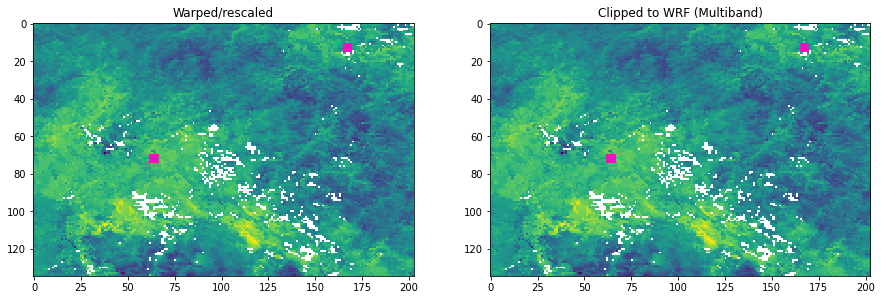

In [33]:
idx1 = [mod11_warp_crop_id, mod12_warp_crop_id]
idx2 = [mod11_out_id, mod12_out_id]
plot_img_arrs(
    mod_warp_crop_sl, 
    mod_out_mb_sl, 
    idx1, 
    idx2, 
    arr1_title="Warped/rescaled", 
    arr2_title="Clipped to WRF (Multiband)", 
    adj1=5, 
    adj2=5
)

And compare with slice from output GeoTIFF:

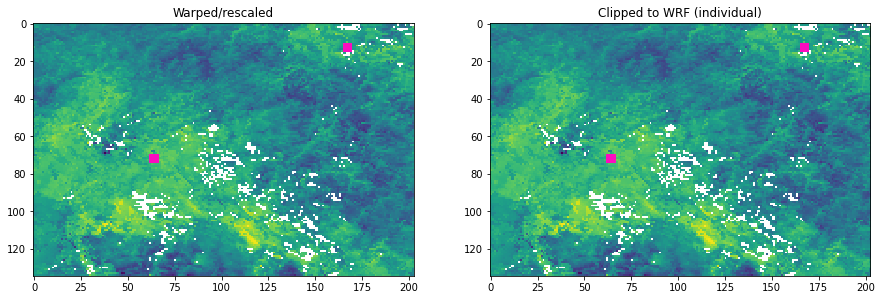

In [34]:
idx2 = [mod11_out_id, mod12_out_id]
plot_img_arrs(
    mod_warp_crop_sl, 
    mod_out_sl, 
    idx1, 
    idx2, 
    arr1_title="Warped/rescaled", 
    arr2_title="Clipped to WRF (individual)", 
    adj1=5, 
    adj2=5
)

Looks good.

### Output MODIS values sanity check

Now to perform basic sanity check on all from all files of output MODIS, to ensure that all values are either `nodata` (NaN) or not extreme. Histograms should suffice. (This also tests that all the files actually open)

In [35]:
def get_all_data(fp):
    with xr.open_dataset(fp) as ds:
        if "lst" in fp:
            return ds.lst.values
        else:
            return ds.tsk.values

In [36]:
mod_out_arr = get_all_data(mod_out_fp)
myd_out_arr = get_all_data(myd_out_fp)

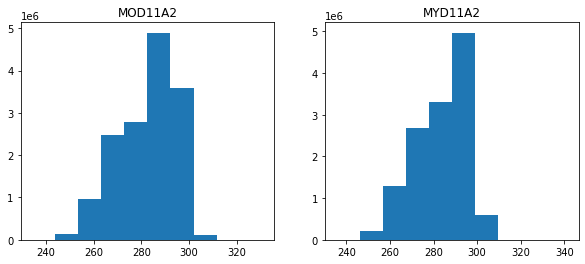

In [37]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))
ax[0].hist(mod_out_arr[~np.isnan(mod_out_arr)])
ax[1].hist(myd_out_arr[~np.isnan(myd_out_arr)])
ax[0].title.set_text("MOD11A2")
ax[1].title.set_text("MYD11A2")
plt.show()

All values appear sane, consider MODIS validated. 

## 2. WRF TSK

### Read raw WRF

In [38]:
# setup
wrf_dir = os.getenv("WRF_DIR")
era_dir = os.path.join(wrf_dir, "era")
# filepaths for each period
wrf_fps = [glob.glob(os.path.join(era_dir, yr, "*.nc")) for yr in ["2008", "2018"]]
wrf_fps = [fp for fp in itertools.chain.from_iterable(wrf_fps)]
# sample filepath
samp_fp = wrf_fps[0]

In [39]:
# get list of variables to drop except time, lat, lon, and tsk
ds = xr.open_dataset(samp_fp)
keep = ["time", "lat", "lon", "TSK"]
drop_vars = [varname for varname in list(ds.variables.keys()) if varname not in keep]
ds.close()

In [40]:
# function to return arr indices of locations
def get_idx(ds, lonlat):
    def dist(arr, lon, lat):
        return math.sqrt((arr[0] - lon)**2 + (arr[1] - lat)**2)
    arr = np.stack((ds.lon.values, ds.lat.values))
    dists = np.apply_along_axis(dist, 0, arr, *lonlat)
    indices = np.where(dists == dists.min())
    return tuple([idx[0] for idx in indices])

In [41]:
# get arr indices of test locations
ds = xr.open_dataset(samp_fp, drop_variables=drop_vars)
L1_idx = get_idx(ds, test_coords[0])
L2_idx = get_idx(ds, test_coords[1])
ds.close()
idxs = [L1_idx, L2_idx]

In [42]:
# get dates for MODIS 8-day start dates
def get_dates(fp, test_dates):
    fp = mod_dates_fp
    dates = pd.read_csv(fp)
    dates = dates.set_index("time")
    dates = [
        dates[str(period[0]): str(period[1])].index.values.astype("datetime64") 
        for period in test_dates
    ]
    start = np.array([arr[0:-1] for arr in dates])
    end = np.array([arr[1:] - 1 for arr in dates])
    return np.stack([start, end], axis=2)

In [43]:
# start dates are equal between MOD and MYD
mod_dates_fp = os.path.join(scratch_dir, "WRF", "resampled", "tsk", "tsk_max_8Day_daytime_wrf_era_2000-2018_times.csv")
dates = get_dates(mod_dates_fp, test_dates)

In [44]:
# subset filepaths by dates for efficiency
fp_dates = [pd.date_range(dates[0], dates[1]).date.tolist() for dates in test_dates]
fp_dates = [str(date) for date in itertools.chain.from_iterable(fp_dates)]
wrf_fps = [fp for fp in wrf_fps if fp.split("_")[-2] in fp_dates]

In [45]:
def get_day_hours(hr):
    return (hr >= 9) & (hr <= 17)

def get_day_hours_ds(ds):
    ds_sel = ds.sel(Time=get_day_hours(ds["time.hour"]))
    return ds_sel

def extr_arrs(ds, dates, idxs):
    arr = ds.TSK.values
    times = pd.to_datetime(ds.time.values)
    # extract from array based on indicies of time array using index slicer
    L1,L2 = [],[]
    out_sl = []
    for period in dates:
        slices = [times.slice_indexer(*daterange) for daterange in period]
        out_sl.append(slices)
        L1.append([np.mean(arr[sl, idxs[0][0], idxs[0][1]]) for sl in slices])
        L2.append([np.mean(arr[sl, idxs[1][0], idxs[1][1]]) for sl in slices])
    # return slices used for WRF as well
    return(np.array([np.array(L1), np.array(L2)]))

In [46]:
tic = time.perf_counter()

# read in raw WRF, takes a couple minutes
ds = xr.open_mfdataset(
    wrf_fps,
    drop_variables=drop_vars + ["lat", "lon"],
    concat_dim="Time",
    combine="nested",
    preprocess=get_day_hours_ds,
).load()
ds.close()

print(round(time.perf_counter() - tic, 1), "s")

40.9 s


In [47]:
wrf_arrs = extr_arrs(ds, dates, idxs)

### Read output WRF

In [48]:
def extr_wrf_out_arrs(ds, coords, dates):
    out_arrs = []
    for coords, pdates in itertools.product(test_coords_3338, dates):
        sds = ds.sel(xc=coords[0], yc=coords[1], method="nearest")
        out_arrs.append(np.array([sds.sel(date=slice(*daterange)).tsk.values[0] for daterange in pdates]))
    out_arrs = np.array([out_arrs[:2], out_arrs[2:]])
    return out_arrs

In [49]:
wrf_out_dir = os.path.join(out_dir, "aligned-WRF-MODIS", "WRF")
wrf_out_fp = glob.glob(os.path.join(wrf_out_dir, "*era*.nc"))[0]
wrf_out_ds = xr.open_dataset(wrf_out_fp)
wrf_out_ds.close()
wrf_out_arrs = extr_wrf_out_arrs(wrf_out_ds, test_coords_3338, dates)

### Compare raw data with output (final)

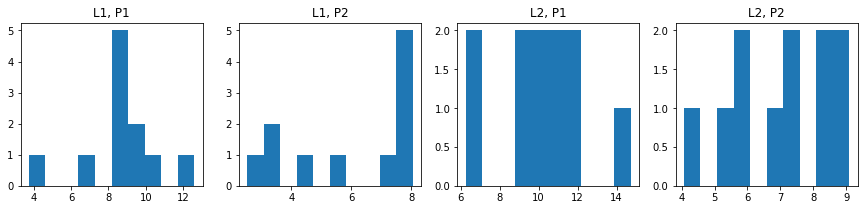

In [50]:
plot_delta_histograms(wrf_out_arrs[0], wrf_out_arrs[1], wrf_arrs[0], wrf_arrs[1])

These are the types of subtle differences I would expect from warping 4326 to 3338. Not to mention that the original grid is irregular in 4326.

### Compare resampled with reprojected

Compare a slice in time between resampled and reprojected:

In [51]:
def get_wrf_resam_reproj(test_date):
    resam_sl_fp = sorted(
        glob.glob(os.path.join(scratch_dir, "WRF", "resampled", f"*/*/*/*era_{test_date}*.tif"))
    )[-1]
    resam_sl = rio.open(resam_sl_fp).read(1)
    resam_sl[resam_sl == -9999] = np.nan
    reproj_sl_fp = sorted(
        glob.glob(os.path.join(scratch_dir, "WRF", "reprojected", "*/*/*era*.nc"))
    )[0]
    with xr.open_dataset(reproj_sl_fp) as ds:
        reproj_sl = ds.sel(date=test_date).tsk.values
    return resam_sl, reproj_sl

Comparison for 2008-04-06:

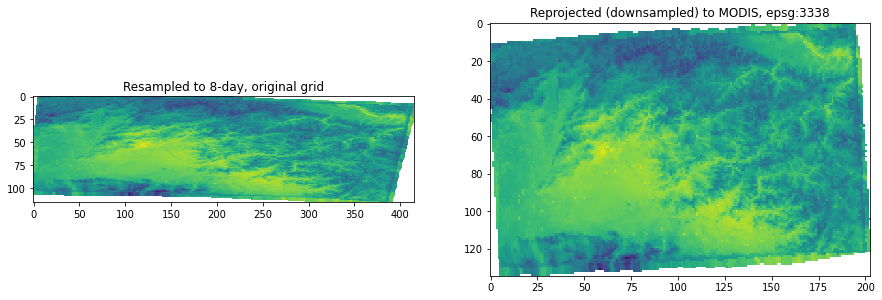

In [52]:
wrf_res_sl, wrf_reproj_sl = get_wrf_resam_reproj("2008-04-06")
vmin = np.nanmin(np.concatenate([wrf_res_sl.flatten(), wrf_reproj_sl.flatten()]))
vmax = np.nanmax(np.concatenate([wrf_res_sl.flatten(), wrf_reproj_sl.flatten()]))
fig, ax = plt.subplots(1,2, figsize=(15,20))
ax[0].imshow(wrf_res_sl, interpolation="none", vmin=vmin, vmax=vmax)
ax[1].imshow(wrf_reproj_sl, interpolation="none", vmin=vmin, vmax=vmax)
ax[0].title.set_text("Resampled to 8-day, original grid")
ax[1].title.set_text("Reprojected (downsampled) to MODIS, epsg:3338")
plt.show()

Comparison for 2018-07-04:

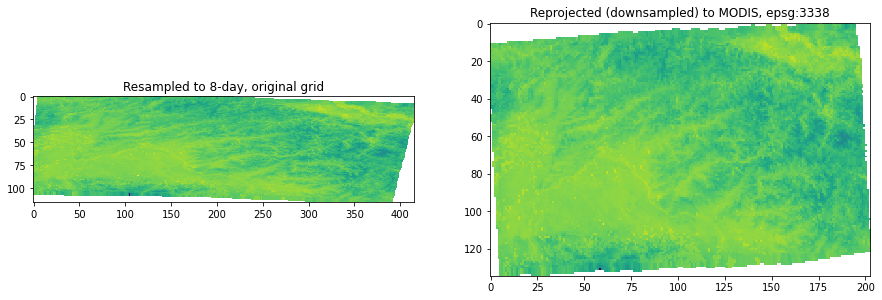

In [53]:
wrf_res_sl, wrf_reproj_sl = get_wrf_resam_reproj("2018-07-04")
vmin = np.nanmin(np.concatenate([wrf_res_sl.flatten(), wrf_reproj_sl.flatten()]))
vmax = np.nanmax(np.concatenate([wrf_res_sl.flatten(), wrf_reproj_sl.flatten()]))
fig, ax = plt.subplots(1,2, figsize=(15,20))
ax[0].imshow(wrf_res_sl, interpolation="none", vmin=vmin, vmax=vmax)
ax[1].imshow(wrf_reproj_sl, interpolation="none", vmin=vmin, vmax=vmax)
ax[0].title.set_text("Resampled to 8-day, original grid")
ax[1].title.set_text("Reprojected (downsampled) to MODIS, epsg:3338")
plt.show()

In [54]:
print("Output MODIS resolution:", mod_out_sl.shape)
print("Regridded WRF resolution:", wrf_reproj_sl.shape)

Output MODIS resolution: (135, 203)
Regridded WRF resolution: (135, 203)


As expected, reprojected example looks the same but is at the same resolution as the MODIS LST.

### Output WRF values sanity check

Now to perform the same basic sanity check on all files of output WRF, to ensure that all values are either `np.nan` or not extreme. 

In [55]:
wrf_out_fps = glob.glob(os.path.join(wrf_out_dir, "*.nc"))
all_data = [get_all_data(fp) for fp in wrf_out_fps]

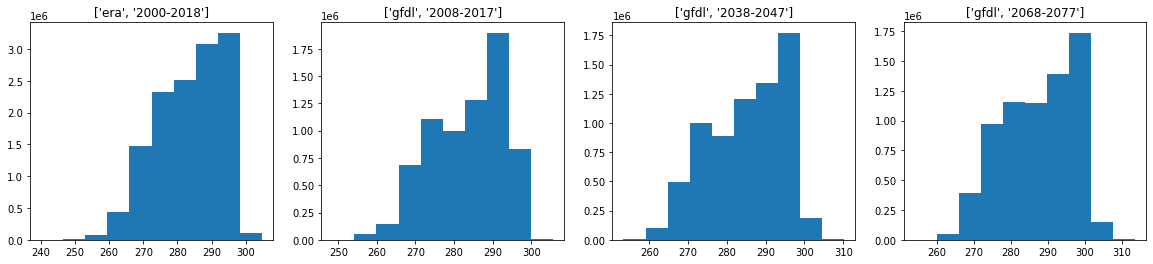

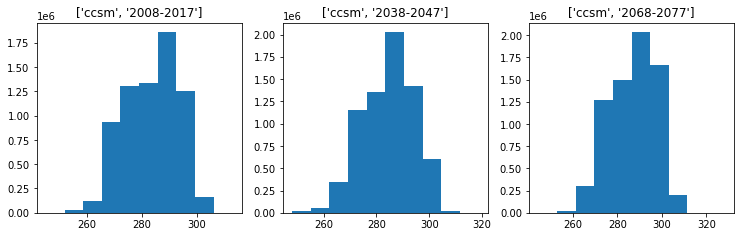

In [56]:
titles = [fp.split("_")[-3:-1] for fp in wrf_out_fps]
fig, ax = plt.subplots(1,4, figsize=(20, 4))
for data, title, axi in zip(all_data[:4], titles[:4], ax):
    axi.hist(data[~np.isnan(data)])
    axi.title.set_text(title)
plt.show()
fig, ax = plt.subplots(1,3, figsize=(12.5, 3.5))
for data, title, axi in zip(all_data[4:], titles[4:], ax):
    axi.hist(data[~np.isnan(data)])
    axi.title.set_text(title)
plt.show()

## 3. WRF-MODIS alignment

Finally, verify that the output data of each source are actually aligned in time and space.

MOD11A2 output sample:

In [57]:
with xr.open_dataset(mod_out_fp) as ds:
    print(ds)

<xarray.Dataset>
Dimensions:  (date: 566, xc: 203, yc: 135)
Coordinates:
  * xc       (xc) float64 1.937e+05 1.954e+05 1.971e+05 ... 5.319e+05 5.336e+05
  * yc       (yc) float64 1.781e+06 1.78e+06 1.778e+06 ... 1.558e+06 1.556e+06
  * date     (date) datetime64[ns] 2000-03-29 2000-04-06 ... 2020-05-16
Data variables:
    lst      (date, yc, xc) float32 ...
    crs      int16 ...
Attributes:
    title:        1km WRF-aligned MODIS LST
    history:      2020-12-03 17:50:28.236672 Python
    Conventions:  CF-1.8
    institution:  Scenarios Network for Alaska + Arctic Planning
    contact:      kmredilla@alaska.edu
    source:       MOD11A2.006 land surface temperature, tiles 11, 12
    version:      1.0.0
    comment:      Intended for use with SERDP research on fish and fire in Al...


WRF output sample:

In [58]:
with xr.open_dataset(wrf_out_fps[0]) as ds:
    print("\nWRF data\n", ds)


WRF data
 <xarray.Dataset>
Dimensions:  (date: 531, xc: 203, yc: 135)
Coordinates:
  * xc       (xc) float64 1.937e+05 1.954e+05 1.971e+05 ... 5.319e+05 5.336e+05
  * yc       (yc) float64 1.781e+06 1.78e+06 1.778e+06 ... 1.558e+06 1.556e+06
  * date     (date) datetime64[ns] 2000-03-29 2000-04-06 ... 2018-11-01
Data variables:
    tsk      (date, yc, xc) float32 ...
    crs      int16 ...
Attributes:
    title:        1km MODIS-aligned WRF TSK
    history:      2020-12-16 03:36:04.052736 Python
    Conventions:  CF-1.8
    institution:  Scenarios Network for Alaska + Arctic Planning
    contact:      kmredilla@alaska.edu
    source:       ERA-Interim downscaled via WRF 4.0
    version:      1.0.0
    comment:      Intended for use with SERDP research on fish and fire in Al...


The `date` dimension is longer for the MODIS dataset because there is more data available (at tail of time series) than for the WRF ERA-Interim. This looks OK - matching values for the coordiantes. 

#### Compare centerpoints

Compare the centerpoints of the first row/column between MODIS and WRF, they should all be equal. Compare one slice in time from all WRF datasets.

In [59]:
with rio.open(f"netcdf:{mod_out_fp}:lst") as src:
    hidx,widx = np.arange(src.height), np.arange(src.width)
    mod_cp_arr = np.array(
        [src.xy(0,j) for j in widx] + [src.xy(i,0) for i in hidx][1:]
    )

In [60]:
# get centerpoints
def get_center_points(fps):
    cp_arrs = []
    for fp in fps:
        with rio.open(f"netcdf:{fp}:tsk") as src:
            hidx,widx = np.arange(src.height), np.arange(src.width)
            cp_arr = np.array(
                [src.xy(0,j) for j in widx] + [src.xy(i,0) for i in hidx][1:]
            )
        cp_arrs.append(cp_arr)
    return cp_arrs

In [61]:
wrf_cp_arrs = get_center_points(wrf_out_fps)

List of comparisons between the MODIS centerpoints and WRF centerpoints: 

In [62]:
np.all([np.all(mod_cp_arr == wrf_cp_arr) for wrf_cp_arr in wrf_cp_arrs])

True

All equal. Finally, visually compare some slices in time from some of the various outputs.

In [63]:
def show_both_src(mod_fp, wrf_fp, date):
    with xr.open_dataset(mod_fp) as ds:
        mod_arr = ds.sel(date=date).lst.values
    with xr.open_dataset(wrf_fp) as ds:
        wrf_arr = ds.sel(date=date).tsk.values
    wrf_mod = wrf_fp.split("_")[-3]
    fig, (mod, wrf) = plt.subplots(1,2, figsize=(16,6))
    show((mod_arr), ax=mod, title=f"MODIS LST, {date}", interpolation="none")
    show((wrf_arr), ax=wrf, title=f"WRF TSK, {wrf_mod}, {date}", interpolation="none")

##### MOD11A2

MOD11A2, ERA-Interim, 2000-03-29

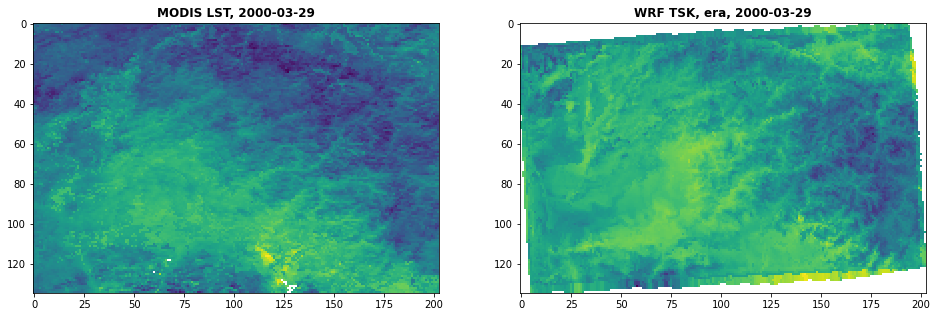

In [64]:
show_both_src(mod_out_fp, wrf_out_fps[0], "2000-03-29")

MOD11A2, GFDL CM3, 2008-03-29

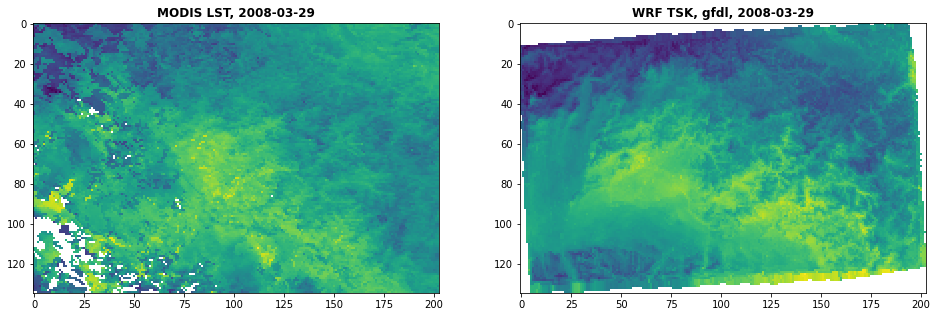

In [65]:
show_both_src(mod_out_fp, wrf_out_fps[1], "2008-03-29")

MOD11A2, NCAR CCSM4, 2008-03-29

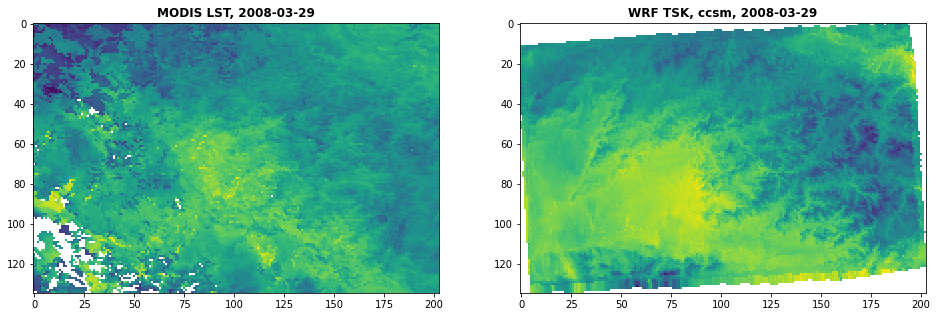

In [66]:
show_both_src(mod_out_fp, wrf_out_fps[4], "2008-03-29")

##### MYD11A2

MYD11A2, ERA-Interim, 2003-03-30

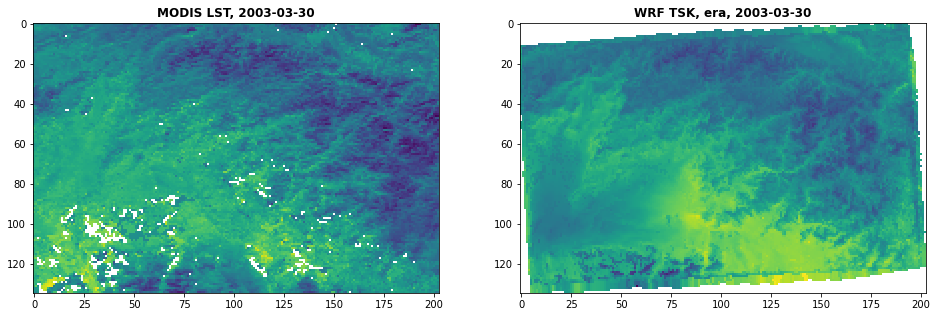

In [67]:
show_both_src(myd_out_fp, wrf_out_fps[0], "2003-03-30")

MYD11A2, GFDL CM3, 2008-03-29

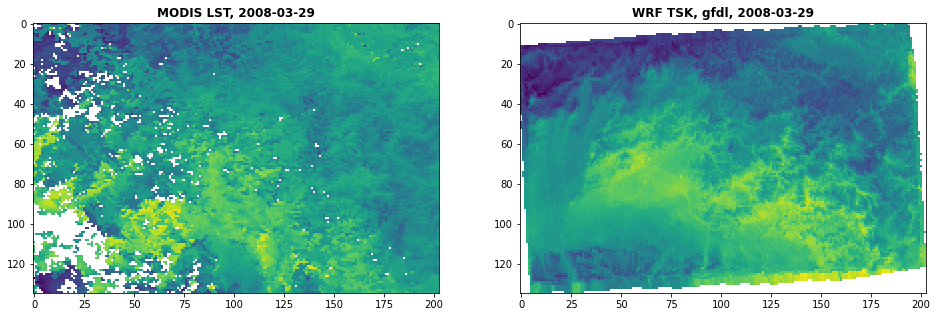

In [68]:
show_both_src(myd_out_fp, wrf_out_fps[1], "2008-03-29")

MYD11A2, NCAR CCSM4, 2008-03-29

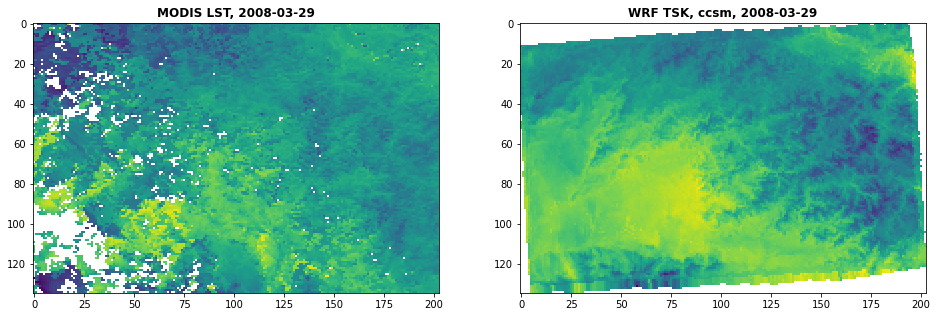

In [69]:
show_both_src(myd_out_fp, wrf_out_fps[4], "2008-03-29")

#### Future WRF

Show some slices from the future WRF datasets, GFDL CM3 and NCAR CCSM4 side-by-side:

In [70]:
def show_both_wrf_src(wrf1_fp, wrf2_fp, date):
    with xr.open_dataset(wrf1_fp) as ds:
        wrf1_arr = ds.sel(date=date).tsk.values
    with xr.open_dataset(wrf2_fp) as ds:
        wrf2_arr = ds.sel(date=date).tsk.values
    wrf1_mod = wrf1_fp.split("_")[-3]
    wrf2_mod = wrf2_fp.split("_")[-3]
    fig, (wrf1, wrf2) = plt.subplots(1,2, figsize=(16,6))
    show((wrf1_arr), ax=wrf1, title=f"WRF TSK, {wrf1_mod}, {date}", interpolation="none")
    show((wrf2_arr), ax=wrf2, title=f"WRF TSK, {wrf2_mod}, {date}", interpolation="none")

2038-03-30

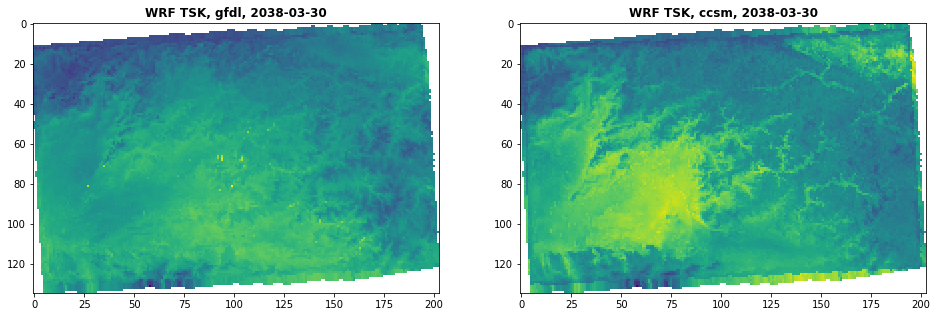

In [71]:
show_both_wrf_src(wrf_out_fps[2], wrf_out_fps[5], "2038-03-30")

2042-07-12

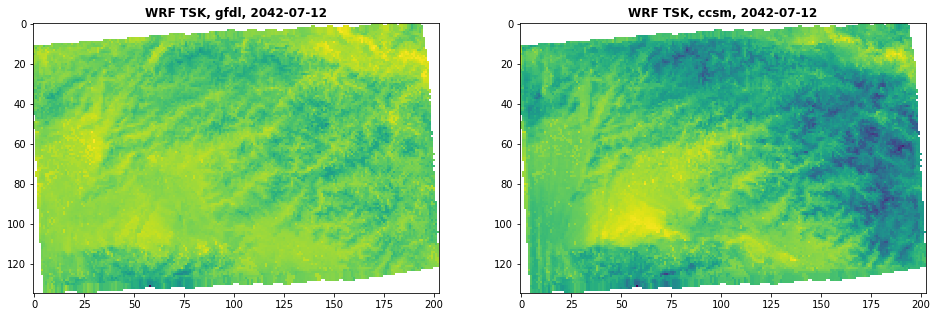

In [72]:
show_both_wrf_src(wrf_out_fps[2], wrf_out_fps[5], "2042-07-12")

2068-03-29

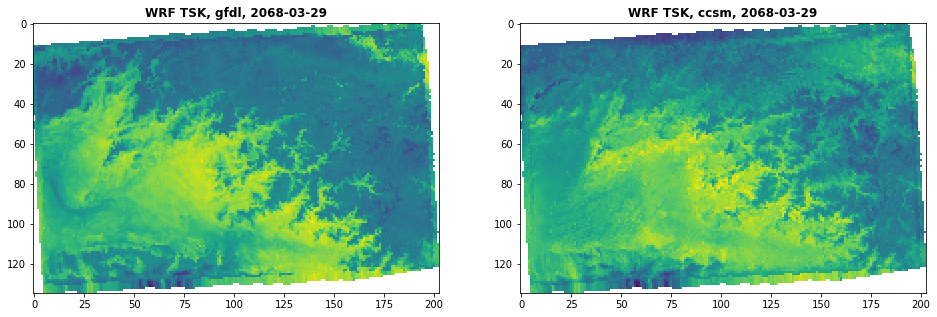

In [73]:
show_both_wrf_src(wrf_out_fps[3], wrf_out_fps[6], "2068-03-29")

2072-07-11

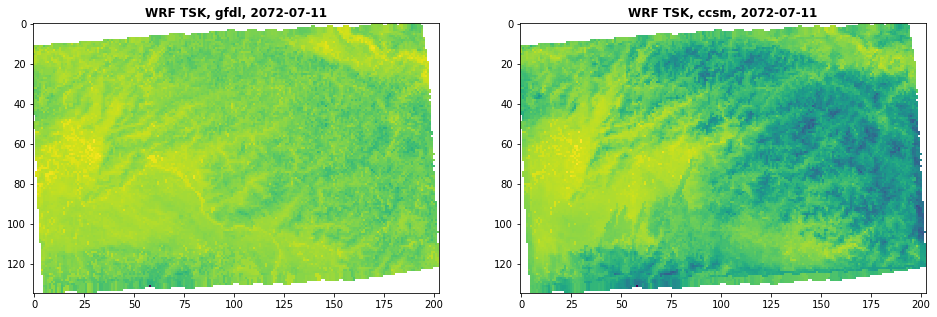

In [74]:
show_both_wrf_src(wrf_out_fps[3], wrf_out_fps[6], "2072-07-11")

All data are aligned and appear to be valid. 